In [1]:
# interactive figure
# %matplotlib widget
%matplotlib inline

# auto reload modules
%load_ext autoreload
%autoreload 2

import warnings
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.ticker as tkr
import matplotlib.gridspec as gridspec
from sys import platform
from IPython.display import HTML, display
from matplotlib.colors import LinearSegmentedColormap

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

def fxn():
    warnings.warn('deprecated', DeprecationWarning)

In [2]:
class FormatScalarFormatter(tkr.ScalarFormatter):
    def __init__(self, fformat='%1.1f', offset=True, mathText=True):
        self.fformat = fformat
        tkr.ScalarFormatter.__init__(self, useOffset=offset, useMathText=mathText)
    def _set_format(self):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

In [3]:
if platform == 'linux' or platform == 'linux2':
    data_root = '/glade/work/zhihuaz/Data/FrontalZone/'
elif platform == 'darwin':
    data_root = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/FrontalZone/Data/'
else:
    print('OS not supported.')

In [8]:
case = 'spinup'
ds = xr.open_dataset(data_root+case+'.nc', group='average').load()
ds.close()

case = 'spinup_no_Vbak'
dsnv = xr.open_dataset(data_root+case+'.nc', group='average').load()
dsnv.close()

case = 'r11-Q000-W022-D00-St0'
# case = 'frontal_zone_wind'
ds_wind = xr.open_dataset(data_root+case+'.nc', group='average').load()
ds_wind.close()
# data_root = '/glade/work/zhihuaz/Data/FrontalZone/' + case
# east_wind = xr.open_dataset(data_root+'_east_slice.nc').load().sel(time=slice('3.5days','7days'))
# south_wind = xr.open_dataset(data_root+'_south_slice.nc').load().sel(time=slice('3.5days','7days'))
# top_wind = xr.open_dataset(data_root+'_top_slice.nc').load().sel(time=slice('3.5days','7days'))
# mfd_wind = xr.open_dataset(data_root+'_averages.nc').load().sel(time=slice('3.5days','7days'))

# case = 'r11-Q000-W022-D180-St0'
# # case = 'frontal_zone_wind'
# ds_windr = xr.open_dataset(data_root+case+'.nc', group='average').load()
# ds_windr.close()

# case = 'r11-Q010-W000-D00-St0'
# ds_conv = xr.open_dataset(data_root+case+'.nc').load()
# ds_conv.close()
# data_root = '/glade/work/zhihuaz/Data/FrontalZone/' + case
# east_conv = xr.open_dataset(data_root+'_east_slice.nc').load().sel(time=slice('3.5days','7days'))
# south_conv = xr.open_dataset(data_root+'_south_slice.nc').load().sel(time=slice('3.5days','7days'))
# top_conv = xr.open_dataset(data_root+'_top_slice.nc').load().sel(time=slice('3.5days','7days'))
# mfd_conv = xr.open_dataset(data_root+'_averages.nc').load().sel(time=slice('3days','7days'))

# case = 'r11-Q000-W022-D00-St1'
# ds_wave = xr.open_dataset(data_root+case+'.nc').load()
# ds_wave.close()
# case_list = pd.Index(['unforced', 'wind', 'conv'], name='case')
# east = xr.concat([east_uf,east_wind,east_conv], case_list)
# south = xr.concat([south_uf,south_wind,south_conv], case_list)
# top = xr.concat([top_uf,top_wind,top_conv], case_list)
# mfd = xr.concat([mfd_uf,mfd_wind,mfd_conv], case_list)

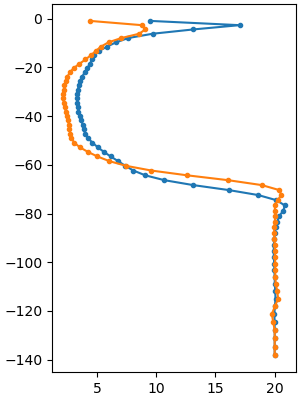

In [6]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

plt.plot(ds['N²hm'].sel(time='6days')*ds.f**2/ds.attrs['M²']**2, ds.zC, '.-');
plt.plot(ds_wind['N²hm'].sel(time='6days')*ds_wind.f**2/ds_wind.attrs['M²']**2, ds_wind.zC, '.-');

### Volume averaged Ertel PV

In [9]:
ds['PV'] = (ds.PVfz.isel(zF=-1) - ds.PVfz.isel(zF=0))/(ds.zF[-1] - ds.zF[0]) - \
            ds.AVx.isel(xF=0)*ds.attrs['M²']
           # +(ds.PVfx.isel(xF=-1) - ds.PVfx.isel(xF=0))/(ds.xF[-1] - ds.xF[0])
dsnv['PV'] = (dsnv.PVfz.isel(zF=-1) - dsnv.PVfz.isel(zF=0))/(dsnv.zF[-1] - dsnv.zF[0]) - \
              dsnv.AVx.isel(xF=0)*dsnv.attrs['M²']
ds_wind['PV'] = (ds_wind.PVfz.isel(zF=-1) - ds_wind.PVfz.isel(zF=0))/(ds_wind.zF[-1] - ds_wind.zF[0]) - \
                 ds_wind.AVx.isel(xF=0)*ds_wind.attrs['M²']
                #+ (ds_wind.PVfx.isel(xF=-1) - ds_wind.PVfx.isel(xF=0))/(ds_wind.xF[-1] - ds_wind.xF[0])
# ds_windr['PV'] = (ds_windr.PVfz.isel(zF=-1) - ds_windr.PVfz.isel(zF=0))/(ds_windr.zF[-1] - ds_windr.zF[0]) - \
#                  ds_windr.AVx.isel(xF=0)*ds_windr.attrs['M²']

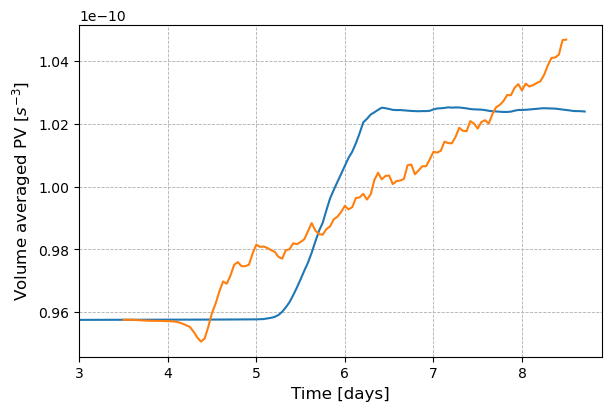

In [14]:
plt.close()
plt.figure(figsize=(6,4), constrained_layout=True)

plt.plot(ds.time/np.timedelta64(1,'D'), ds.PV)
plt.plot(ds_wind.time/np.timedelta64(1,'D'), ds_wind.PV)
# plt.plot(dsnv.time/np.timedelta64(1,'D'), dsnv.PV)
plt.grid('on', ls='--', lw=0.6)
plt.xlim(3,8.9)
plt.xlabel('Time [days]', fontsize=12);
plt.ylabel(r'Volume averaged PV [$s^{-3}$]', fontsize=12);

# plt.savefig('../Figures/volume_averaged_PV.png', dpi=150)

### Bulk $N^2$ budget

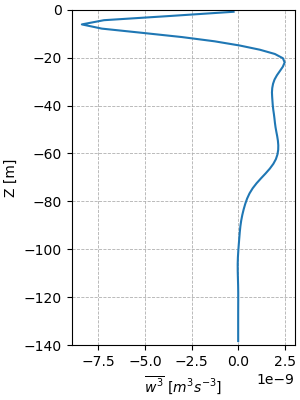

In [39]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)
# plt.plot(ds_wind.w2ym.mean('xC').sel(time=slice('7.8days','8.5days')).mean('time'), ds_wind.zC)
plt.plot(ds_wind.w3ym.mean('xC').sel(time=slice('7.8days','8.5days')).mean('time'), ds_wind.zC)
# plt.plot(ds_wind.wbym.mean('xC').sel(time=slice('7.8days','8.5days')).mean('time'), ds_wind.zC)
# plt.plot(ds_wind.B.mean('xC').sel(time=slice('7.8days','8.5days')).mean('time'), ds_wind.zC)

plt.ylim(-140,0)
plt.grid('on', ls='--', lw=0.6)
# plt.xlabel(r'$\overline{b}$ $[m s^{-2}]$')
# plt.xlabel(r'$\overline{w^2}$ $[m^2 s^{-2}]$')
plt.xlabel(r'$\overline{w^3}$ $[m^3 s^{-3}]$')
# plt.xlabel(r'$\overline{wb}$ $[m^2 s^{-3}]$')
plt.ylabel('Z [m]');

In [35]:
zt = -1
zb = -120
H = ds_wind.zC.sel(zC=zt, method='nearest') - ds_wind.zC.sel(zC=zb, method='nearest')

ds_wind['dN2dt']     = (ds_wind['∂ₜB'].sel(zC=zt, method='nearest')-ds_wind['∂ₜB'].sel(zC=zb, method='nearest'))/H
ds_wind['dN2dt_adb'] = (ds_wind.Badb.sel(zC=zt, method='nearest')-ds_wind.Badb.sel(zC=zb, method='nearest'))/H
ds_wind['dN2dt_adv'] = (ds_wind.Badv.sel(zC=zt, method='nearest')-ds_wind.Badv.sel(zC=zb, method='nearest'))/H
ds_wind['dN2dt_dia'] = (ds_wind.Bdia.sel(zC=zt, method='nearest')-ds_wind.Bdia.sel(zC=zb, method='nearest'))/H

ds_windr['dN2dt']     = (ds_windr['∂ₜB'].sel(zC=zt, method='nearest')-ds_windr['∂ₜB'].sel(zC=zb, method='nearest'))/H
ds_windr['dN2dt_adb'] = (ds_windr.Badb.sel(zC=zt, method='nearest')-ds_windr.Badb.sel(zC=zb, method='nearest'))/H
ds_windr['dN2dt_adv'] = (ds_windr.Badv.sel(zC=zt, method='nearest')-ds_windr.Badv.sel(zC=zb, method='nearest'))/H
ds_windr['dN2dt_dia'] = (ds_windr.Bdia.sel(zC=zt, method='nearest')-ds_windr.Bdia.sel(zC=zb, method='nearest'))/H

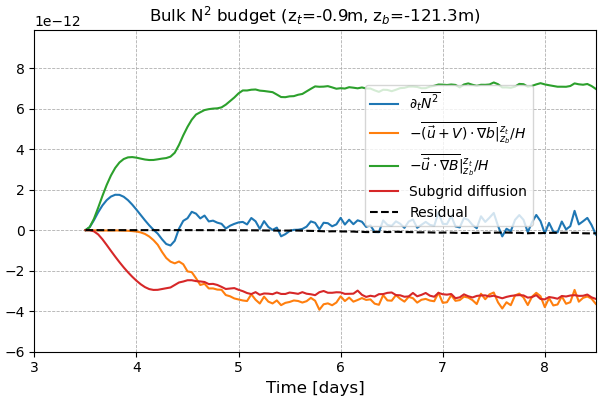

In [23]:
plt.close()
plt.figure(figsize=(6,4), constrained_layout=True)

plt.plot(ds_wind.time/np.timedelta64(1,'D'), ds_wind.dN2dt)
plt.plot(ds_wind.time/np.timedelta64(1,'D'), ds_wind.dN2dt_adv)
plt.plot(ds_wind.time/np.timedelta64(1,'D'), ds_wind.dN2dt_adb)
plt.plot(ds_wind.time/np.timedelta64(1,'D'), ds_wind.dN2dt_dia)
plt.plot(ds_wind.time/np.timedelta64(1,'D'), ds_wind.dN2dt-ds_wind.dN2dt_adv-ds_wind.dN2dt_adb-ds_wind.dN2dt_dia,
         '--k')
plt.grid('on', ls='--', lw=0.6)
plt.xlim(3,8.5);
plt.ylim(-6e-12,9.9e-12);
plt.xlabel('Time [days]', fontsize=12);
plt.legend([r'$\partial_t \overline{N^2}$', r'$-\overline{(\vec{u}+V) \cdot\nabla b} |^{z_t}_{z_b}/H$', 
            r'$-\overline{\vec{u} \cdot\nabla B} |^{z_t}_{z_b}/H$', 'Subgrid diffusion', 'Residual'], 
           loc='upper right', bbox_to_anchor=(0.9, 0.85))
plt.title(r'Bulk N$^2$ budget (z$_t$=-0.9m, z$_b$=-121.3m)');
plt.savefig('../Figures/r11-Q000-W022-D00-St0_bulkN2.png', dpi=150)

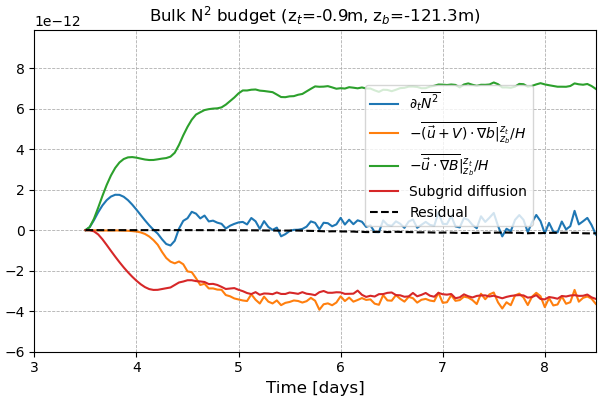

In [25]:
plt.close()
plt.figure(figsize=(6,4), constrained_layout=True)

plt.plot(ds_windr.time/np.timedelta64(1,'D'), ds_windr.dN2dt)
plt.plot(ds_windr.time/np.timedelta64(1,'D'), ds_windr.dN2dt_adv)
plt.plot(ds_windr.time/np.timedelta64(1,'D'), ds_windr.dN2dt_adb)
plt.plot(ds_windr.time/np.timedelta64(1,'D'), ds_windr.dN2dt_dia)
plt.plot(ds_windr.time/np.timedelta64(1,'D'), ds_windr.dN2dt-ds_windr.dN2dt_adv-ds_windr.dN2dt_adb-ds_windr.dN2dt_dia,
         '--k')
plt.grid('on', ls='--', lw=0.6)
plt.xlim(3,8.5);
plt.ylim(-6e-12,9.9e-12);
plt.xlabel('Time [days]', fontsize=12);
plt.legend([r'$\partial_t \overline{N^2}$', r'$-\overline{(\vec{u}+V) \cdot\nabla b} |^{z_t}_{z_b}/H$', 
            r'$-\overline{\vec{u} \cdot\nabla B} |^{z_t}_{z_b}/H$', 'Subgrid diffusion', 'Residual'], 
           loc='upper right', bbox_to_anchor=(0.9, 0.85))
plt.title(r'Bulk N$^2$ budget (z$_t$=-0.9m, z$_b$=-121.3m)');
# plt.savefig('../Figures/r11-Q000-W022-D00-St0_bulkN2.png', dpi=150)

In [7]:
H = ds.zC[-1] - ds.zC.sel(zC=-100, method='nearest')
ds['Bhm'] = ds.B.mean('xC')
ds['BadX'] = (ds.U.interp(xF=ds.xC)*ds.Bt.differentiate('xC')).mean('xC')
ds['dN2dt'] = (ds.Bhm.isel(zC=-1)-ds.Bhm.sel(zC=-100, method='nearest')).differentiate('time',datetime_unit='s')/H
ds['dN2dt_adH'] = -(ds.BadH.isel(zC=-1)-ds.BadH.sel(zC=-100, method='nearest'))/H
ds['dN2dt_adX'] = -(ds.BadX.isel(zC=-1)-ds.BadX.sel(zC=-100, method='nearest'))/H
ds['dN2dt_adV'] = -(ds.BadV.isel(zC=-1)-ds.BadV.sel(zC=-100, method='nearest'))/H
ds['dN2dt_dia'] = -(ds.Bdia.isel(zC=-1)-ds.Bdia.sel(zC=-100, method='nearest'))/H

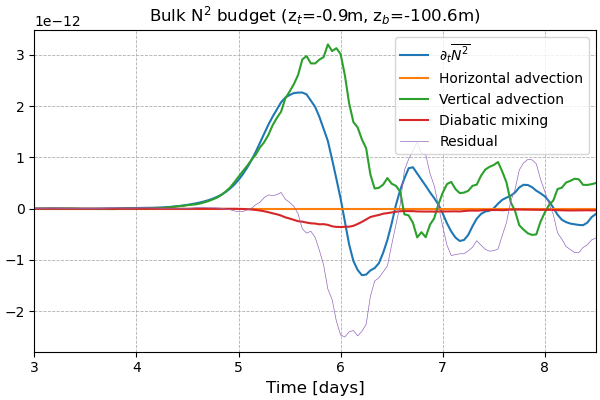

In [8]:
plt.close()
plt.figure(figsize=(6,4), constrained_layout=True)

plt.plot(ds.time/np.timedelta64(1,'D'), ds.dN2dt)
plt.plot(ds.time/np.timedelta64(1,'D'), ds.dN2dt_adH)
plt.plot(ds.time/np.timedelta64(1,'D'), ds.dN2dt_adV)
plt.plot(ds.time/np.timedelta64(1,'D'), ds.dN2dt_dia)
plt.plot(ds.time/np.timedelta64(1,'D'), ds.dN2dt-ds.dN2dt_adH-ds.dN2dt_adV-ds.dN2dt_dia, lw=0.5)
plt.grid('on', ls='--', lw=0.6)
plt.xlim(3,8.5);
plt.xlabel('Time [days]', fontsize=12);
plt.legend([r'$\partial_t \overline{N^2}$', 'Horizontal advection', 'Vertical advection', 'Diabatic mixing', 'Residual'], 
           loc='upper right', bbox_to_anchor=(1, 1))
plt.title(r'Bulk N$^2$ budget (z$_t$=-0.9m, z$_b$=-100.6m)');

### Mean KE, mean stratification, mean vertical buoyancy flux

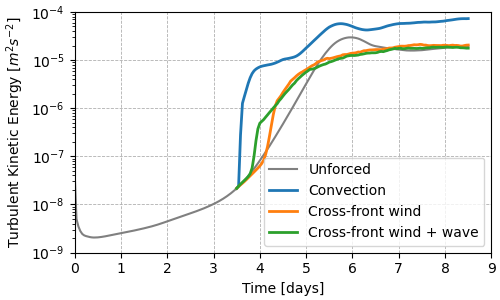

In [51]:
plt.close()
plt.figure(figsize=(5,3), constrained_layout=True)

plt.plot(ds.time/np.timedelta64(1,'D'), ds.KE, color='gray', lw=1.5)
plt.plot(ds_conv.time/np.timedelta64(1,'D'), ds_conv.KE, lw=2)
plt.plot(ds_wind.time/np.timedelta64(1,'D'), ds_wind.KE, lw=2)
plt.plot(ds_wave.time/np.timedelta64(1,'D'), ds_wave.KE, lw=2)
plt.grid('on', ls='--', lw=0.6)
plt.legend(['Unforced', 'Convection', 'Cross-front wind',  'Cross-front wind + wave'])
plt.ylabel(r'Turbulent Kinetic Energy [$m^2 s^{-2}$]')
plt.xlabel('Time [days]');
plt.yscale('log')
plt.xlim(0,9);
plt.ylim(1e-9, 1e-4);
plt.savefig('../Figures/all_KE.png', dpi=150)

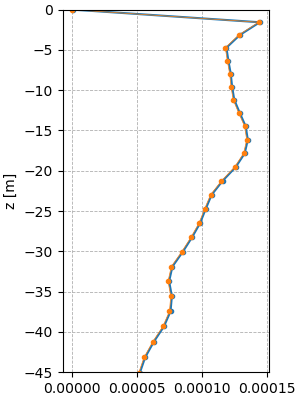

In [6]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

plt.plot(east['νₑ'].isel(time=23).mean('yC'), mfd.zF, '.-')
plt.plot(east['κₑ'].isel(time=23).mean('yC'), mfd.zF, '.-', lw=0.5)

# plt.xscale('log')
plt.grid('on', ls='--', lw=0.6)
plt.ylim(-45,0)
plt.ylabel('z [m]');


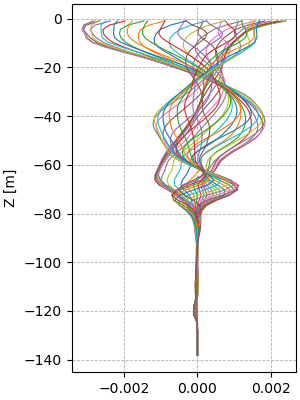

In [133]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

# plt.plot(ds['B'].sel(time='7.5 days').mean('xC'), ds.zC, '--k')
plt.plot(ds['U'].sel(time=slice('5.5 days','6 days')).mean('xF').T, ds.zC, lw=0.8)

# plt.xscale('symlog')
plt.grid('on', ls='--', lw=0.6)
# plt.ylim(-140,0)
plt.ylabel('Z [m]');

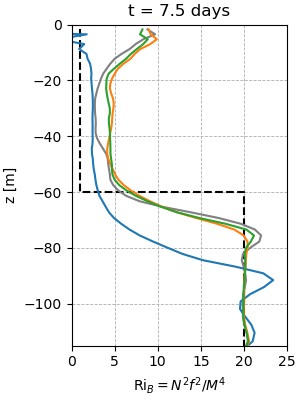

In [78]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

plt.plot([1,1,20,20], [ds.zF[-2],-60,-60,-140], '--k')
plt.plot(ds.RiB.sel(time='7.5 days', method='nearest')[:-1], ds.zF[:-1], color='gray');
plt.plot(ds_conv.RiB.sel(time='7.5 days', method='nearest')[:-1], ds_conv.zF[:-1]);
plt.plot(ds_wind.RiB.sel(time='7.5 days', method='nearest')[:-1], ds_wind.zF[:-1]);
plt.plot(ds_wave.RiB.sel(time='7.5 days', method='nearest')[:-1], ds_wave.zF[:-1]);

plt.grid('on', ls='--', lw=0.6)
plt.xlim(0,25)
plt.ylim(-115,0)
plt.title('t = 7.5 days')
plt.xlabel(r'Ri$_B = N^2f^2/M^4$')
plt.ylabel('z [m]');
plt.savefig('../Figures/all_RiBprof.png', dpi=150)

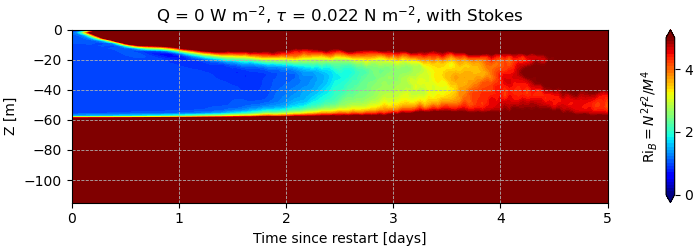

In [77]:
plt.close()
fig = plt.figure(figsize=(7,2.5), constrained_layout=True)

CRiB = plt.contourf((ds_wave.time-np.timedelta64(3*24+12,'h'))/np.timedelta64(1,'D'), 
                     ds_wave.zF, 
                     ds_wave.RiB.transpose('zF','time'), 
                     np.linspace(0,5,50), extend='both', cmap='jet')

cbar = fig.colorbar(CRiB, ax=plt.gca(), fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.0f'))
cbar.set_label(r'Ri$_B = N^2f^2/M^4$', labelpad=-40)
cbar.ax.set_yticks([0,2,4])

plt.grid('on', ls='--', lw=0.6)
plt.xlim(0,5)
plt.ylim(-115,0)
plt.xlabel('Time since restart [days]');
plt.ylabel('Z [m]');
plt.title(r'Q = 0 W m$^{-2}$, $\tau$ = 0.022 N m$^{-2}$, with Stokes')
case = 'r11-Q000-W022-D00-St1'
plt.savefig('../Figures/'+case+'_RiB_TZ.png', dpi=150);

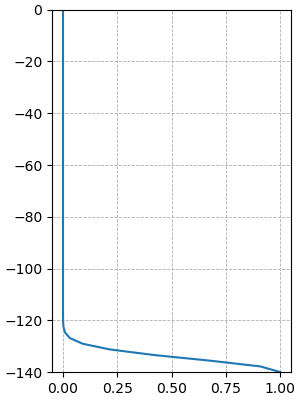

In [13]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

z = np.linspace(-140,0,65)
plt.plot(np.exp( -(z+140)**2/(2*5**2) ) , z)#* np.heaviside(-120-z,0)
# plt.plot((1+np.tanh( 1.5*(-135-z)/10 ))/2, z)
plt.grid('on', ls='--', lw=0.6);
plt.ylim(-140,0);

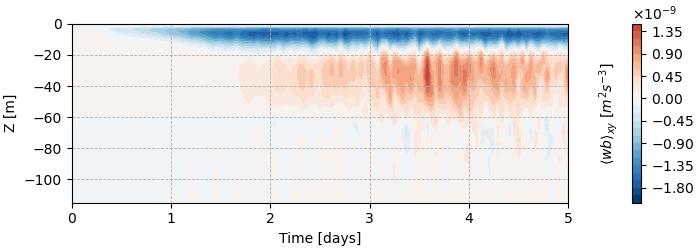

In [86]:
plt.close()
fig = plt.figure(figsize=(7,2.5), constrained_layout=True)

# Cwb = plt.contourf((mfd_uf.time-np.timedelta64(3*24+12,'h'))/np.timedelta64(1,'D'), mfd_uf.zC, 
#                      mfd_uf.wb.mean('xC').transpose('zC','time'), 32, 
#                      norm=mcolors.CenteredNorm(), cmap='RdBu_r')
# Cwb = plt.contourf((mfd_wind.time-np.timedelta64(3*24+12,'h'))/np.timedelta64(1,'D'), mfd_wind.zC, 
#                      mfd_wind.wb.mean('xC').transpose('zC','time'), 32, 
#                      norm=mcolors.CenteredNorm(), cmap='RdBu_r')
Cwb = plt.contourf((ds_wave.time.sel(time=slice('3.5 days',None))-np.timedelta64(3*24+12,'h'))/np.timedelta64(1,'D'), 
                    ds_wave.zC, 
                    ds_wave.wb.mean('xC').transpose('zC','time').sel(time=slice('3.5 days',None)), 32,
                    norm=mcolors.CenteredNorm(), cmap='RdBu_r')
cbar = fig.colorbar(Cwb, ax=plt.gca(), fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r"$\langle wb \rangle_{xy}$ [$m^2 s^{-3}$]", labelpad=-70)
cbar.ax.yaxis.set_offset_position('left')
# cbar.ax.set_yticks([0,2,4])

plt.grid('on', ls='--', lw=0.6)
plt.xlim(0,5)
plt.ylim(-115,0)
plt.xlabel('Time [days]');
plt.ylabel('Z [m]');

# plt.title(r'Q = -10 W m$^{-2}$, $\tau$ = 0 N m$^{-2}$')
# case = 'spinup'
# case = 'r11-Q010-W000-D00-St0'
# case = 'r11-Q000-W022-D00-St0'
# plt.savefig('../Figures/'+case+'_wb_TZ.png', dpi=150)

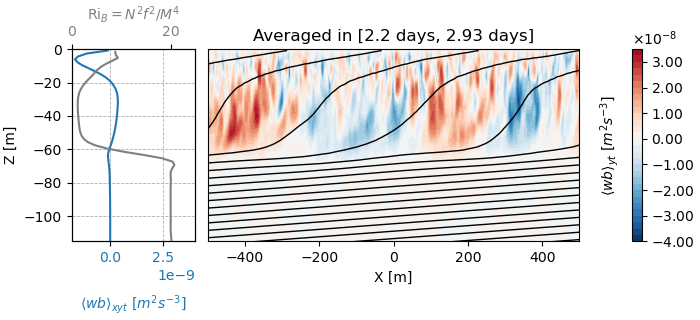

In [85]:
plt.close()
fig = plt.figure(figsize=(7,3.2), constrained_layout=True)
gs = gridspec.GridSpec(1, 4, figure=fig)

# itime = slice('5 days', '5.73 days')
itime = slice('5.2 days', '5.93 days')
ax0 = fig.add_subplot(gs[0, :1])
color = 'C0'
# ax0.plot(mfd_uf.wb.sel(time=itime).mean(['time','xC']), mfd_uf.zC, color=color);
ax0.plot(ds_wind.wb.sel(time=itime).mean(['time','xC']), ds_wind.zC, color=color);
# ax0.plot(mfd_conv.wb.sel(time=itime).mean(['time','xC']), mfd_conv.zC, color=color);
ax0.grid('on', ls='--', lw=0.6)
ax0.set_xlim(-1.8e-9,4e-9)
ax0.set_ylabel('Z [m]');
ax0.set_xlabel(r"$\langle wb \rangle_{xyt}$ [$m^2 s^{-3}$]", labelpad=20, color=color);
ax0.tick_params(axis='x', labelcolor=color)

ax0t = ax0.twiny()
color = 'gray'
# ax0t.plot(mfd_uf.RiB.sel(time=itime).mean('time')[:-1], mfd_uf.zF[:-1], color=color)
ax0t.plot(ds_wind.RiB.sel(time=itime).mean('time')[:-1], ds_wind.zF[:-1], color=color)
# ax0t.plot(mfd_conv.RiB.sel(time=itime).mean('time')[:-1], mfd_conv.zF[:-1], color=color)
ax0t.set_xlim(0,25)
ax0t.set_xlabel(r'Ri$_B = N^2f^2/M^4$', color=color)
ax0t.tick_params(axis='x', labelcolor=color)

kw = {
    # 'vmin': -7e-8,
    # 'vmax': 7e-8,
    'norm': mcolors.CenteredNorm(),
    # 'shading': 'gouraud',
    'levels': 31,#np.linspace(-7e-8, 7e-8, 24),
    'cmap': 'RdBu_r'
}
ax1 = fig.add_subplot(gs[0, 1:], sharey=ax0)
# Cwb = ax1.contourf(mfd_uf.xC, mfd_uf.zC, mfd_uf['wb'].sel(time=itime).mean('time'), **kw)
Cwb = ax1.contourf(ds_wind.xC, ds_wind.zC, ds_wind['wb'].sel(time=itime).mean('time'), **kw)
# Cwb = ax1.contourf(mfd_conv.xC, mfd_uf.zC, mfd_conv['wb'].sel(time=itime).mean('time'), **kw)

# ax1.contour(mfd_uf.xC, mfd_uf.zC, mfd_uf.Bt.sel(time=itime).mean('time'), 
#               np.arange(0,1.9,0.08)*1e-4, colors='k', linewidths=1)
ax1.contour(ds_wind.xC, ds_wind.zC, ds_wind.Bt.sel(time=itime).mean('time'), 
            np.arange(0,1.9,0.08)*1e-4, colors='k', linewidths=1)
# ax1.contour(mfd_conv.xC, mfd_conv.zC, mfd_conv.Bt.sel(time=itime).mean('time'), 
#               np.arange(0,1.9,0.08)*1e-4, colors='k', linewidths=1)

cbar = fig.colorbar(Cwb, ax=ax1, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r"$\langle wb \rangle_{yt}$ [$m^2 s^{-3}$]", labelpad=-70)
cbar.ax.yaxis.set_offset_position('left')
plt.ylim(-115,0)
ax1.axes.get_yaxis().set_visible(False)
ax1.set_title('Averaged in [2.2 days, 2.93 days]')#f't = {(itime)//24} days, {(itime)%24} hours')
ax1.set_xlabel('X [m]');

# case = 'spinup'
# case = 'r11-Q000-W022-D00-St0'
# case = 'r11-Q010-W000-D00-St0'

# plt.savefig('../Figures/'+case+'_wb_XZ_time_mean.png', dpi=150)

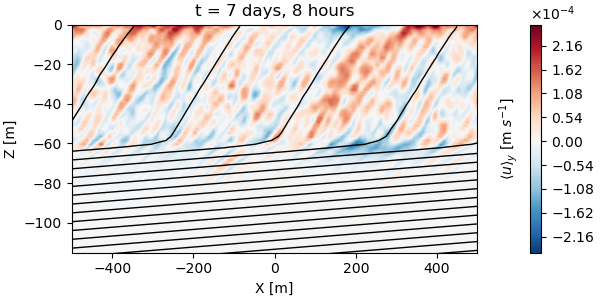

In [25]:
plt.close()
fig = plt.figure(figsize=(6,3), constrained_layout=True)
ax = fig.add_subplot(111)

itime = 166-72
kw0 = {
    # 'vmin': -5e-3,
    # 'vmax': 5e-3,
    'norm': mcolors.CenteredNorm(),
    'levels': 100, #np.linspace(-1e-5, 1e-5, 100),
    'cmap': 'RdBu_r'
}

Cu = ax.contourf(mfd.xF, mfd.zC, mfd.U.isel(time=itime), **kw0)
ax.contour(mfd.xC, mfd.zC, mfd.B.isel(time=itime)+bak.B.isel(yC=0), 
              np.arange(0,1.9,0.08)*1e-4, colors='k', linewidths=1)

cbar = fig.colorbar(Cu, ax=ax, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r'$\langle u\rangle_{y}$ [m $s^{-1}$]', labelpad=-70)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
ax.set_title(f't = {(itime+72)//24} days, {(itime+72)%24} hours')
ax.set_ylim(-115,0)
ax.set_ylabel('Z [m]');
ax.set_xlabel('X [m]');

# plt.savefig('../Figures/'+case+'_UtransectXZ.png', dpi=150)

### Surface map

In [24]:
###patch start###
from mpl_toolkits.mplot3d.axis3d import Axis
if not hasattr(Axis, "_get_coord_info_old"):
    def _get_coord_info_new(self, renderer):
        mins, maxs, centers, deltas, tc, highs = self._get_coord_info_old(renderer)
        mins += deltas / 4
        maxs -= deltas / 4
        return mins, maxs, centers, deltas, tc, highs
    Axis._get_coord_info_old = Axis._get_coord_info  
    Axis._get_coord_info = _get_coord_info_new
###patch end###

In [4]:
# bak = xr.open_dataset('/glade/work/zhihuaz/Data/FrontalZone/bak.nc').load()
# bak.close()

case = 'spinup'
fpath = '/glade/work/zhihuaz/Data/FrontalZone/'+case+'.nc'
top = xr.open_dataset(fpath, group='slice/top').load()#.chunk('auto')
top.close()
z_top_slice = top.zC[0]
south = xr.open_dataset(fpath, group='slice/south').load().sel(zC=slice(None,z_top_slice))#.chunk('auto')
south.close()
y_south_slice = south.yC[0]
east = xr.open_dataset(fpath, group='slice/east').load().sel(zC=slice(None,z_top_slice))#.chunk('auto')
east.close()
x_east_slice = east.xC[0]# ds_average = xr.open_dataset(data_root+case+'_averages.nc').load()
# ds_average.close()

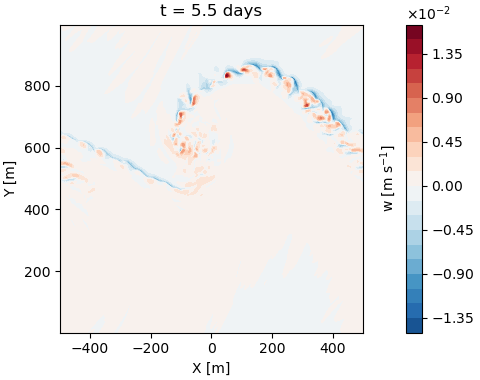

In [9]:
plt.close()
fig = plt.figure(figsize=(4.8,3.8), constrained_layout=True)
ax = fig.add_subplot(111)

itime = '5.5 days'
xroll = 0

kw = {
    # 'vmin': -5e-3,
    # 'vmax': 5e-3,
    'norm': mcolors.CenteredNorm(),
    'levels': 20, #np.linspace(-5e-3, 5e-3, 22),
    'cmap': 'RdBu_r',
    # 'extend': 'both'
}

Ct = plt.contourf(top.xC, top.yC, top.w.sel(time=itime, method='nearest').squeeze().roll(xC=xroll,yC=0), **kw);
cbar = fig.colorbar(Ct, ax=ax, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r'w [m s$^{-1}$]', labelpad=-70)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
# cbar.ax.set_yticks(np.linspace(-5e-3, 5e-3, 6))
cbar.ax.yaxis.set_offset_position('left')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title(f't = {itime}');
# plt.savefig('../Figures/wtop_217.png', dpi=150);

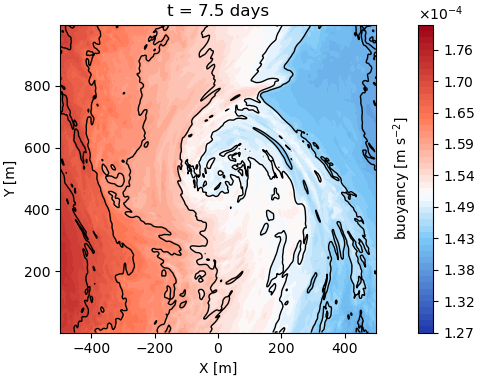

In [6]:
colorlist = ['xkcd:sapphire', 'xkcd:lightblue', 'xkcd:pale grey', 'xkcd:melon', 'xkcd:carmine']
nodes = [0.0, 0.3, 0.45, 0.7, 1.0]
cmap = LinearSegmentedColormap.from_list('buoyancy', list(zip(nodes, colorlist)))

itime = '7.5 days'
xroll = 0

bmin = (ds_top.b.isel(zC=0) + bak.B.isel(zC=-6)).min()
bmax = (ds_top.b.isel(zC=0) + bak.B.isel(zC=-6)).max()
bmin = np.floor(bmin*1e6)/1e6
bmax = np.ceil(bmax*1e6)/1e6
kw = {
    'vmin': bmin,
    'vmax': bmax,
    'levels': np.linspace(bmin, bmax, 50),
    'cmap': cmap#'Spectral_r'
}

plt.close()
fig = plt.figure(figsize=(4.8,3.8), constrained_layout=True)
ax = fig.add_subplot(111)

Ct = ax.contourf(ds_top.xC, ds_top.yC, ds_top.b.sel(time=itime, method='nearest').squeeze().roll(xC=xroll,yC=0) + bak.B.isel(zC=-6), **kw);
ax.contour(ds_top.xC, ds_top.yC, ds_top.b.sel(time=itime, method='nearest').squeeze().roll(xC=xroll,yC=0) + bak.B.isel(zC=-6), linewidths=1, colors='k')
ax.set_title(f't = {itime}')#{itime//24} days, {itime%24} hours')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
cbar = fig.colorbar(Ct, ax=ax, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.2f'))
cbar.set_label(r'buoyancy [m s$^{-2}$]', labelpad=-60)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
# plt.savefig('../Figures/btop_217.png', dpi=150)

# def update(frame):
#     global Ct, top, bak, kw, xroll
#     # for each frame, get new data and clear old data stored on each artist
#     top_field = (top.b.isel(time=frame,zC=0).roll(xC=xroll,yC=0)  + bak.B.isel(zC=-1))
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore')
#         for coll in Ct.collections:
#             coll.remove()
#     # update the plot
#     Ct = ax.contourf(top.xC, top.yC, top_field, **kw)
#     ax.set_title(f't = {frame//24} days, {frame%24} hours');
#     return Ct

# ani = animation.FuncAnimation(fig=fig, func=update, frames=top.dims['time'], #top.dims['time']
#                               interval=120, repeat_delay=100, blit=True);
# plt.close()
# display(HTML(ani.to_jshtml()));
# ani.save('../Figures/'+case+'_btop.mp4', writer='ffmpeg', fps=5, dpi=150);

### 3D snapshot/movie

#### buoyancy field

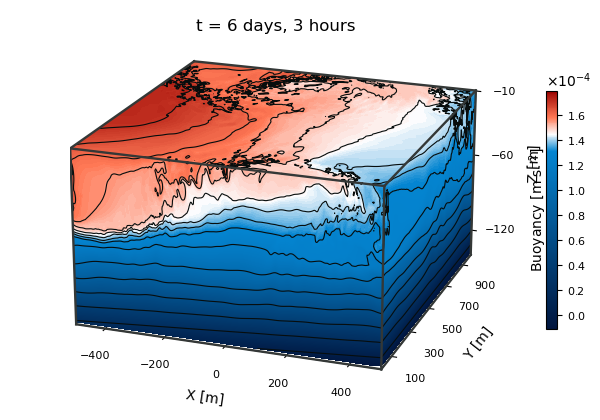

In [76]:
# customized colormap
colorlist = ['xkcd:navy', 'xkcd:cerulean', 'xkcd:pale grey', 'xkcd:melon', 'xkcd:deep red']
nodes = [0.0, 0.75, 0.82, 0.89, 1.0]
cmap = LinearSegmentedColormap.from_list('buoyancy', list(zip(nodes, colorlist)))

# total buoyancy
top['bt']   = (-top.attrs['M²']   * top.xC   + top.b).squeeze().transpose('yC','xC',...)
south['bt'] = (-south.attrs['M²'] * south.xC + south.b).squeeze().transpose('xC','zC',...)
east['bt']  = (-east.attrs['M²']  * east.xC  + east.b).squeeze().transpose('yC','zC',...)

# time interval and initial timestamp in unit of hours
dhr = int(((top.time[2] - top.time[1])/np.timedelta64(1,'h')).data)
hr0 = int((top.time[0]/np.timedelta64(1,'h')).data)

X, Y, Z = np.meshgrid(top.xC, top.yC, east.zC)

# limits and contour values
bmin = min([top.bt.min(), east.bt.min(), south.bt.min()])
bmax = max([top.bt.max(), east.bt.max(), south.bt.max()])
bmin = np.ceil(bmin*1e6)/1e6
bmax = np.floor(bmax*1e6)/1e6
blines = np.concatenate([np.arange(0,1.4,0.2), np.arange(1.3,2,0.05)])*1e-4
xmin, xmax = -500, 500
ymin, ymax = 0, 1000
zmin, zmax = -140, z_top_slice.data

Ckw = {'vmin': bmin,
       'vmax': bmax,
       'levels': np.linspace(bmin, bmax, 256),
       'cmap': cmap
      }
Lkw = {'linewidths': 0.8, 
       'colors': 'xkcd:almost black'
      }
edges_kw = {'color': 'xkcd:charcoal', 
            'linewidth': 1.7, 
            'zorder': 2
           }

fig = plt.figure(figsize=(6,4.2), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
itime = 147
xroll = 0

Ct = ax.contourf(X[:, :, -1], Y[:, :, -1], top.bt.isel(time=itime).roll(xC=xroll), zdir='z', offset=z_top_slice, **Ckw)
Cs = ax.contourf(X[0, :, :], south.bt.isel(time=itime).roll(xC=xroll), Z[0, :, :], zdir='y', offset=y_south_slice, **Ckw)
# xroll doesn't work for east slice!!
Ce = ax.contourf(east.bt.isel(time=itime), Y[:, -1, :], Z[:, -1, :], zdir='x', offset=x_east_slice, **Ckw)

Lt = ax.contour(X[:, :, -1], Y[:, :, -1], top.bt.isel(time=itime).roll(xC=xroll), blines, zdir='z', offset=z_top_slice, **Lkw)
Ls = ax.contour(X[0, :, :], south.bt.isel(time=itime).roll(xC=xroll), Z[0, :, :], blines, zdir='y', offset=y_south_slice, **Lkw)
Le = ax.contour(east.bt.isel(time=itime), Y[:, -1, :], Z[:, -1, :], blines, zdir='x', offset=x_east_slice, **Lkw)

ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
ax.plot([xmin, xmin], [ymin, ymax], zmax, **edges_kw)
ax.plot([xmin, xmax], [ymax, ymax], zmax, **edges_kw)
ax.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.set(xlabel='X [m]',
       ylabel='Y [m]',
       zlabel='Z [m]',
       zticks=[-10, -60, -120],
       xticks=[-400, -200, 0, 200, 400],
       yticks=[100, 300, 500, 700, 900],
       xlim=[xmin, xmax], 
       ylim=[ymin, ymax], 
       zlim=[zmin, zmax])
ax.tick_params(axis='both', labelsize=8)
ax.view_init(20, -70, 0)
ax.set_box_aspect((1,1,0.58), zoom=1.17)
ax.set_title(f't = {(itime*dhr + hr0)//24} days, {(itime*dhr + hr0)%24} hours', y=0.995);
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

cbar = fig.colorbar(Ct, ax=ax, fraction=0.025, pad=0.1, ticks=np.arange(0,2,0.2)*1e-4, 
                    format=FormatScalarFormatter('%.1f'))
cbar.set_label(r'Buoyancy [m s$^{-2}$]', labelpad=-42, fontsize=10)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.tick_params(labelsize=8) 

# def update(frame):
#     global Ct, Cs, Ce, Lt, Ls, Le
#     # for each frame, get new data and clear old data stored on each artist
#     top_field   = top.bt.isel(time=frame).roll(xC=xroll)
#     south_field = south.bt.isel(time=frame).roll(xC=xroll)
#     east_field  = east.bt.isel(time=frame)
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore')
#         for obj in (Ct, Cs, Ce, Lt, Ls, Le):
#             for coll in obj.collections:
#                 coll.remove()
#     # update the plot
#     Ct = ax.contourf(X[:, :, -1], Y[:, :, -1], top_field,   zdir='z', offset=z_top_slice,   **Ckw)
#     Cs = ax.contourf(X[0, :, :], south_field,  Z[0, :, :],  zdir='y', offset=y_south_slice, **Ckw)
#     Ce = ax.contourf(east_field, Y[:, -1, :],  Z[:, -1, :], zdir='x', offset=x_east_slice,  **Ckw)
#     Lt = ax.contour(X[:, :, -1], Y[:, :, -1], top_field,   blines, zdir='z', offset=z_top_slice,   **Lkw)
#     Ls = ax.contour(X[0, :, :],  south_field, Z[0, :, :],  blines, zdir='y', offset=y_south_slice, **Lkw)
#     Le = ax.contour(east_field,  Y[:, -1, :], Z[:, -1, :], blines, zdir='x', offset=x_east_slice,  **Lkw)
#     ax.set_title(f't = {(frame*dhr + hr0)//24} days, {(frame*dhr + hr0)%24} hours', y=0.995)
#     return Ct, Cs, Ce, Lt, Ls, Le

# ani = animation.FuncAnimation(fig=fig, func=update, frames=3,#top.dims['time'], 
#                               interval=400, repeat_delay=800)# blit=True);#
# plt.close()
# display(HTML(ani.to_jshtml()));
# ani.save('../Figures/'+case+'_b3d.mp4', writer='ffmpeg', fps=3, dpi=200);

#### vertical velocity field

/glade/scratch/zhihuaz/ipykernel_75864/4213078828.py:102: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  Ce = ax.contourf(east_field, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), **kw)
/glade/scratch/zhihuaz/ipykernel_75864/4213078828.py:100: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  Ct = ax.contourf(X[:, :, -1], Y[:, :, -1], top_field, zdir='z', offset=0, **kw)
/glade/scratch/zhihuaz/ipykernel_75864/4213078828.py:101: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  Cs = ax.contourf(X[0, :, :], south_field, Z[0, :, :], zdir='y', offset=0, **kw)
/glade/scratch/zhihuaz/ipykernel_75864/4213078828.py:102: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  Ce = ax.contourf(east_field, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), **kw)


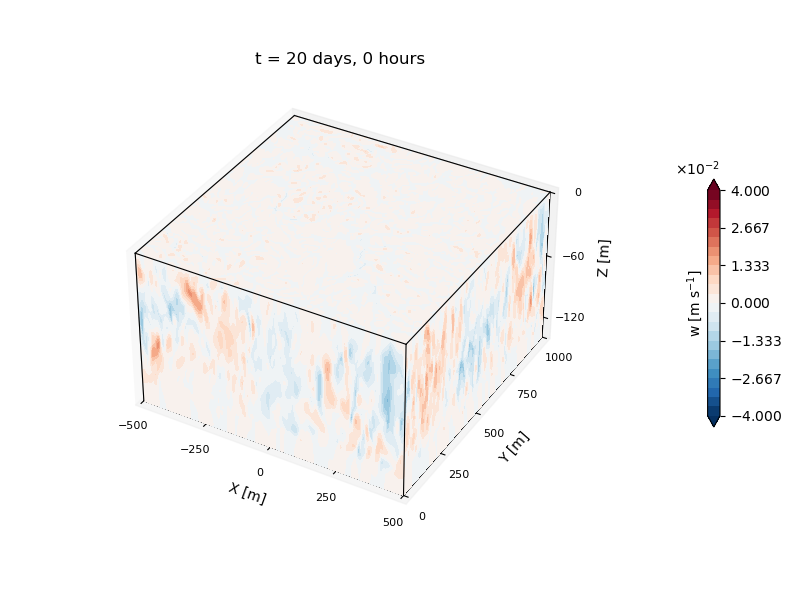

In [42]:
X, Y, Z = np.meshgrid(south.xC, east.yC, east.zF)
itime = 0

wmin = min([top.w.isel(zF=0).min(), 
            east.w.isel(xC=0).min(), 
            south.w.isel(yC=0).min()])
wmax = max([top.w.isel(zF=0).max(), 
            east.w.isel(xC=0).max(), 
            south.w.isel(yC=0).max()])
wamp = np.floor(max([abs(wmin), abs(wmax)])*1e2)/1e2

kw = {
    'vmin': -wamp,
    'vmax': wamp,
    'levels': np.linspace(-wamp, wamp, 25),
    'cmap': 'RdBu_r',
    'extend': 'both'
}

# Create a figure with 3D ax
plt.close()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
Ct = ax.contourf(
    X[:, :, -1], Y[:, :, -1], top.w.isel(time=itime,zF=0).transpose('yC','xC'),
    zdir='z', offset=0, **kw
)
Cs = ax.contourf(
    X[0, :, :], south.w.isel(time=itime,yC=0).transpose('xC','zF'), Z[0, :, :],
    zdir='y', offset=0, **kw
)
Ce = ax.contourf(
    east.w.isel(time=itime,xC=0).transpose('yC','zF'), Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
# --

# Plot edges
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymax], [zmax, zmax], **edges_kw)
ax.plot([xmin, xmax], [ymax, ymax], [zmax, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [m]',
    ylabel='Y [m]',
    zlabel='Z [m]',
    zticks=[0, -60, -120],
    xticks=[-500, -250, 0, 250, 500],
    yticks=[0, 250, 500, 750, 1000]
)
ax.tick_params(axis='both', labelsize=8)

# Set zoom and angle view
ax.view_init(35, -60, 0)
ax.set_box_aspect((1,1,0.6), zoom=1)

# Colorbar
cbar = fig.colorbar(Ce, ax=ax, fraction=0.02, pad=0.22)
cbar.set_label(r'w [m s$^{-1}$]', labelpad=-70)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.set_yticks(np.linspace(-wamp, wamp, 7))

# Set limits of the plot from coord limits
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax]);
ax.set_title(f't = {itime//24} days, {itime%24} hours');

# plt.savefig('../Figures/b3d_initial.png', dpi=150)
# plt.savefig('../Figures/b3d_mid.png', dpi=150)


def update(frame):
    global Ct, Cs, Ce, top, south, east, X, Y, Z, kw
    # for each frame, get new data and clear old data stored on each artist
    top_field = top.w.isel(time=frame,zF=0).transpose('yC','xC')
    south_field = south.w.isel(time=frame,yC=0).transpose('xC','zF')
    east_field = east.w.isel(time=frame,xC=0).transpose('yC','zF')
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for coll in Ct.collections:
            coll.remove()
        for coll in Cs.collections:
            coll.remove()
        for coll in Ce.collections:
            coll.remove()
    # update the plot
    Ct = ax.contourf(X[:, :, -1], Y[:, :, -1], top_field, zdir='z', offset=0, **kw)
    Cs = ax.contourf(X[0, :, :], south_field, Z[0, :, :], zdir='y', offset=0, **kw)
    Ce = ax.contourf(east_field, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), **kw)
    ax.set_title(f't = {frame//24} days, {frame%24} hours');
    return (Ct, Cs, Ce)

ani = animation.FuncAnimation(fig=fig, func=update, frames=top.dims['time'], interval=120, repeat_delay=100);#
plt.close()
display(HTML(ani.to_jshtml()));
ani.save('../Figures/'+case+'_w3d.mp4', writer='ffmpeg', fps=5, dpi=150);

In [61]:
np.sqrt(1.8e-6)

0.0013416407864998738